In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import h5py

import sys
sys.path.append('../../../src')
from utils import smooth_curve
from viz import show_images
from PlumeDataset import plume_dataset
from AutoAlign import align_plumes
from Velocity import VelocityCalculator
from PlumeMetrics import PlumeMetrics
from HorizontalLineProfileAnalyzer import HorizontalLineProfileAnalyzer
from AutoAlign import visualize_corners
from analyze_function import analyze_function

## show example plumes

In [2]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
print(keys)
plumes = plume_ds.load_plumes('1-SrRuO3')
print(plumes.shape)

['1-SrRuO3', '1-SrRuO3_Pre']
(380, 128, 250, 400)


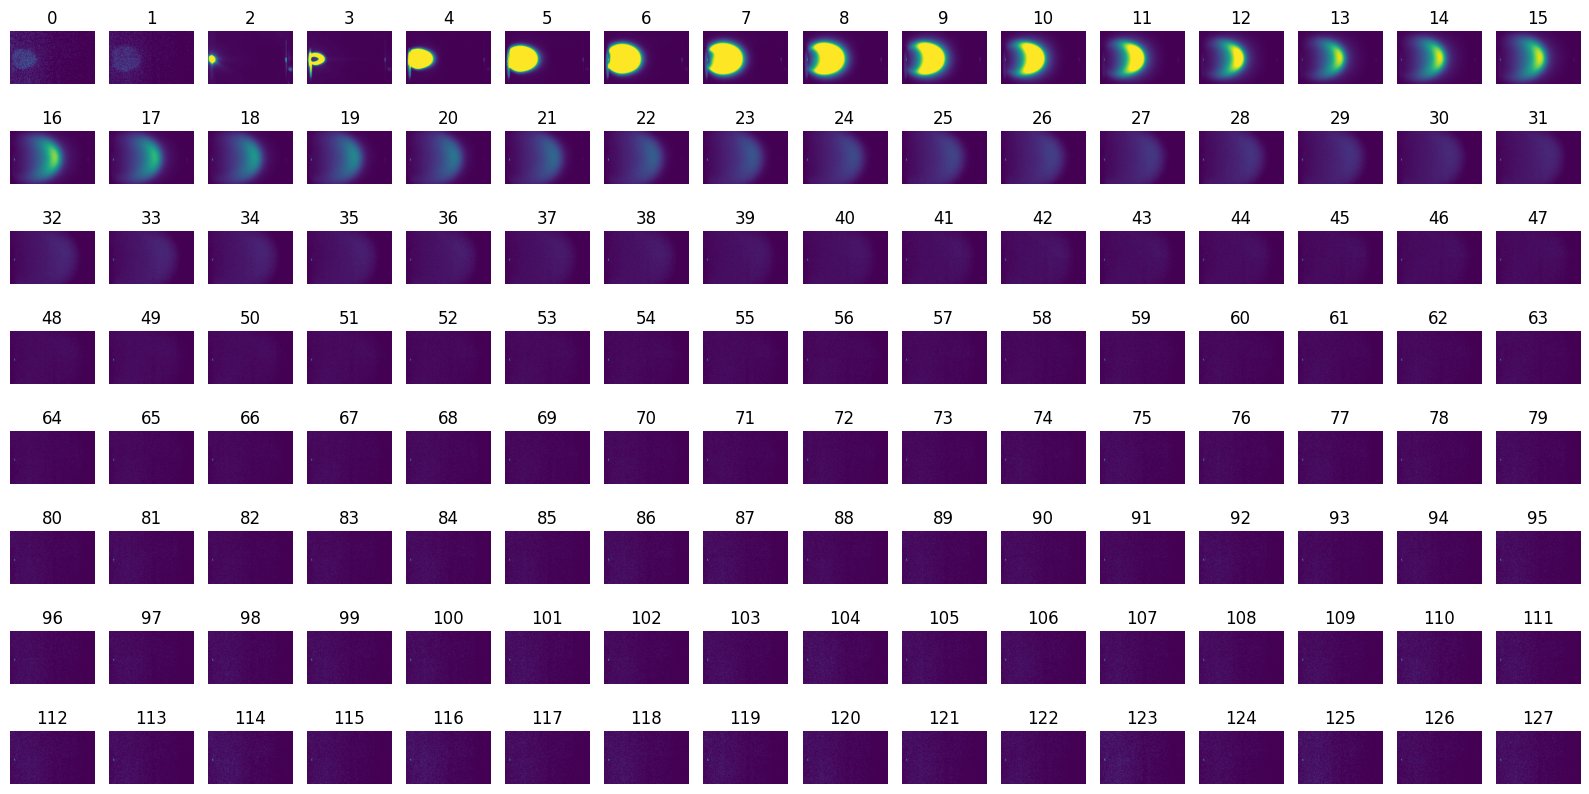

In [3]:
show_images(plumes[0], img_per_row=16)

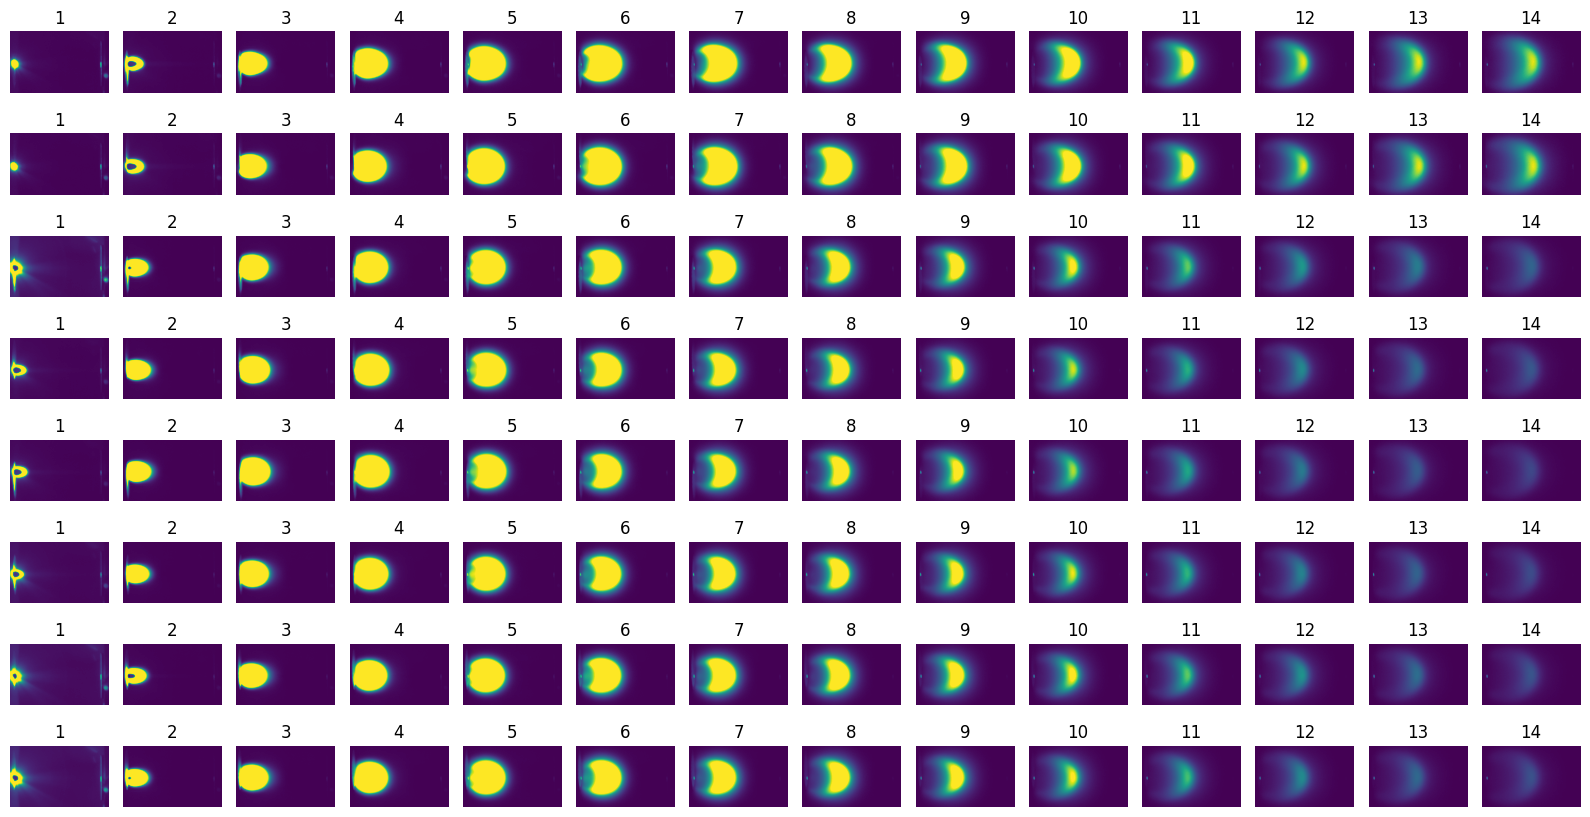

In [4]:
plumes_target = plumes[::50, 2:16]
labels = list(range(1, plumes_target.shape[1]+1))*len(plumes_target)

plumes_target = plumes_target.reshape(plumes_target.shape[0]*plumes_target.shape[1], plumes_target.shape[2], plumes_target.shape[3])
show_images(plumes_target, img_per_row=14, labels=labels)

## same condition: YG056, YG063 - 100 mTorr, 1.6 J/cm^2

In [5]:
df_condition = pd.read_excel('../../../datasets/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[[30, 24, 27, 34, 29, 32, 33], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
# df_condition.replace('2 to 1.73', (2+1.73)/2, inplace=True)
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)

# print('Pressure (mTorr):', df_condition['Pressure (mTorr)'].unique())
# print('Temperature (C):', df_condition['Temperature (C)'].unique())
# print('Fluence (J/cm2):', df_condition['Fluence (J/cm2)'].unique())
# print('Repetation rate (Hz):', df_condition['Repetation rate (Hz)'].unique())
df_condition

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
30,YG059,50.0,700,1.6,5.0
24,YG053,75.0,700,1.6,5.0
27,YG056,100.0,700,1.6,5.0
34,YG063,100.0,700,1.6,5.0
29,YG058,125.0,700,1.6,5.0
32,YG061,150.0,700,1.6,5.0
33,YG062,175.0,700,1.6,5.0


In [6]:
df_condition['Growth'].unique()

array(['YG059', 'YG053', 'YG056', 'YG063', 'YG058', 'YG061', 'YG062'],
      dtype=object)

In [7]:
df_plume_all = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../../datasets/SRO_plume_metrics/{key}*.csv')[0]
    df = pd.read_csv(file)
    df_plume_all.append(df)
df_plume_all = pd.concat(df_plume_all)
df_condition['Growth'].unique()

array(['YG059', 'YG053', 'YG056', 'YG063', 'YG058', 'YG061', 'YG062'],
      dtype=object)

In [8]:
df_plume_all

,plume_index,time_index,Distance,Velocity,Area,Threshold,Growth
0,0,0,0,0.0,0.0,200,YG059
1,0,1,0,0.0,0.0,200,YG059
2,0,2,82,164000000.0,2200.0,200,YG059
3,0,3,134,104000000.0,7479.0,200,YG059
4,0,4,164,60000000.0,12764.0,200,YG059
...,...,...,...,...,...,...,...
143611,373,123,292,0.0,0.0,flexible,YG062
143612,373,124,292,0.0,0.0,flexible,YG062
143613,373,125,292,0.0,0.0,flexible,YG062
143614,373,126,292,0.0,0.0,flexible,YG062


In [9]:
df_merged = pd.merge(df_condition, df_plume_all, on='Growth')
df_merged['Growth+Pressure'] = df_merged['Growth'] + '_' + df_merged['Pressure (mTorr)'].astype(str)
df_merged_hotcore = df_merged[df_merged['Threshold']=='200']
df_merged_hotcore.sample(10)

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz),plume_index,time_index,Distance,Velocity,Area,Threshold,Growth+Pressure
767472,YG062,175.0,700,1.6,5.0,340,112,192,0.0,0.0,200,YG062_175.0
146275,YG053,75.0,700,1.6,5.0,200,99,221,0.0,0.0,200,YG053_75.0
454760,YG058,125.0,700,1.6,5.0,156,104,204,0.0,0.0,200,YG058_125.0
759048,YG062,175.0,700,1.6,5.0,275,8,173,12000000.0,10141.0,200,YG062_175.0
139552,YG053,75.0,700,1.6,5.0,148,32,218,0.0,0.0,200,YG053_75.0
325532,YG063,100.0,700,1.6,5.0,287,28,201,0.0,0.0,200,YG063_100.0
600975,YG061,150.0,700,1.6,5.0,171,15,197,0.0,5.0,200,YG061_150.0
731131,YG062,175.0,700,1.6,5.0,56,123,191,0.0,0.0,200,YG062_175.0
32956,YG059,50.0,700,1.6,5.0,257,60,230,0.0,0.0,200,YG059_50.0
593311,YG061,150.0,700,1.6,5.0,111,31,199,0.0,0.0,200,YG061_150.0


In [10]:
for key in df_plume_all['Growth'].unique():
    print(key)
    print(df_plume_all[df_plume_all['Growth']==key]['Threshold'].unique())

YG059
['200' '5' 'flexible']
YG053
['200' '5' 'flexible']
YG056
['200' '5' 'flexible']
YG063
['200' '5' 'flexible']
YG058
['200' '5' 'flexible']
YG061
['200' '5' 'flexible']
YG062
['200' '5' 'flexible']


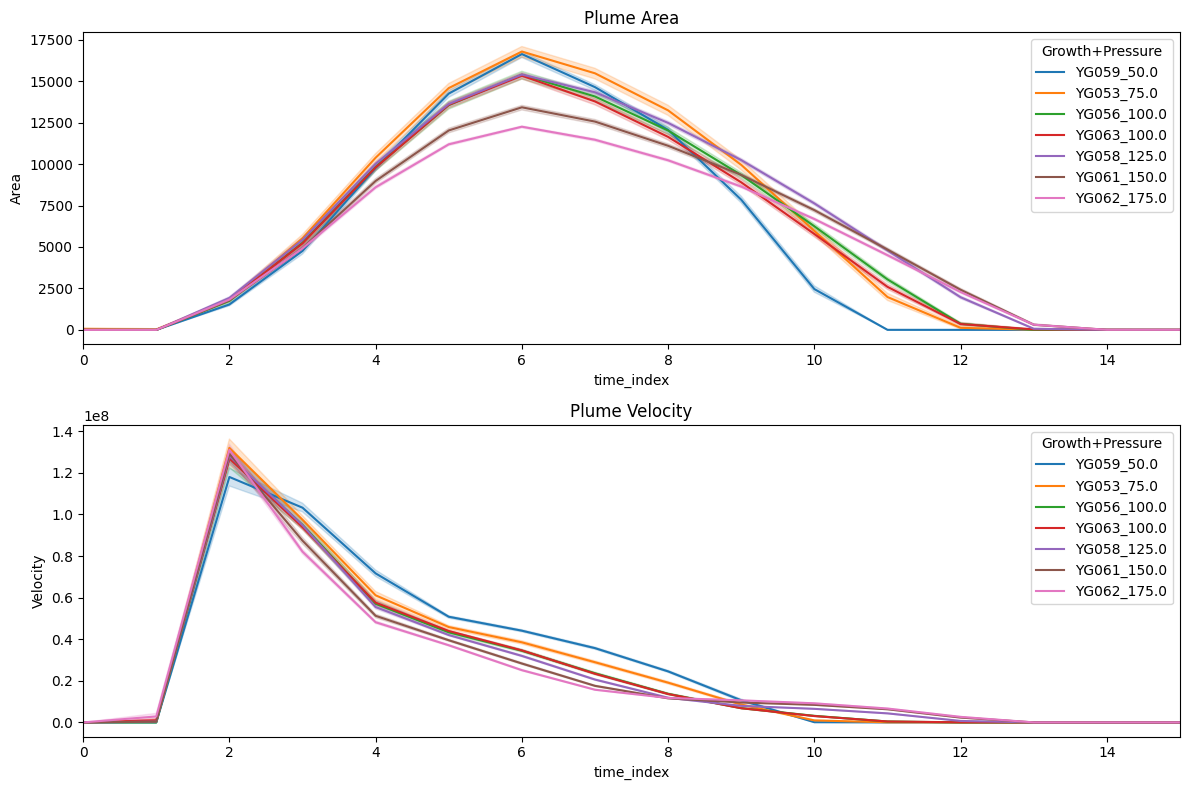

In [11]:
label = 'Growth+Pressure'

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Area", hue=label, data=df_merged_hotcore, ax=axes[0])
axes[0].set_title('Plume Area')
axes[0].set_xlim(0, 15)
lineplot = sns.lineplot(x="time_index", y="Velocity", hue=label, data=df_merged_hotcore, ax=axes[1])
axes[1].set_title('Plume Velocity')
axes[1].set_xlim(0, 15)
plt.tight_layout()
plt.show()

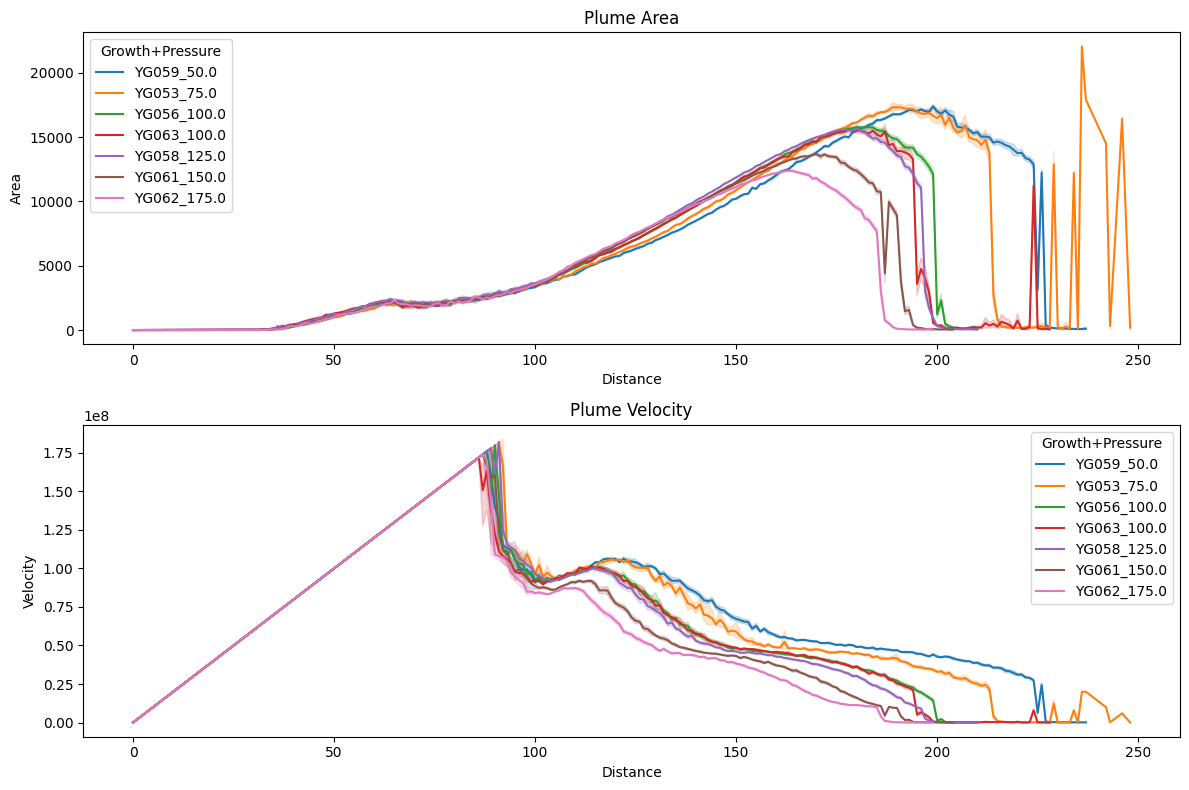

In [12]:
label = 'Growth+Pressure'

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="Distance", y="Area", hue=label, data=df_merged_hotcore, ax=axes[0])
axes[0].set_title('Plume Area')
lineplot = sns.lineplot(x="Distance", y="Velocity", hue=label, data=df_merged_hotcore, ax=axes[1])
axes[1].set_title('Plume Velocity')
plt.tight_layout()
plt.show()

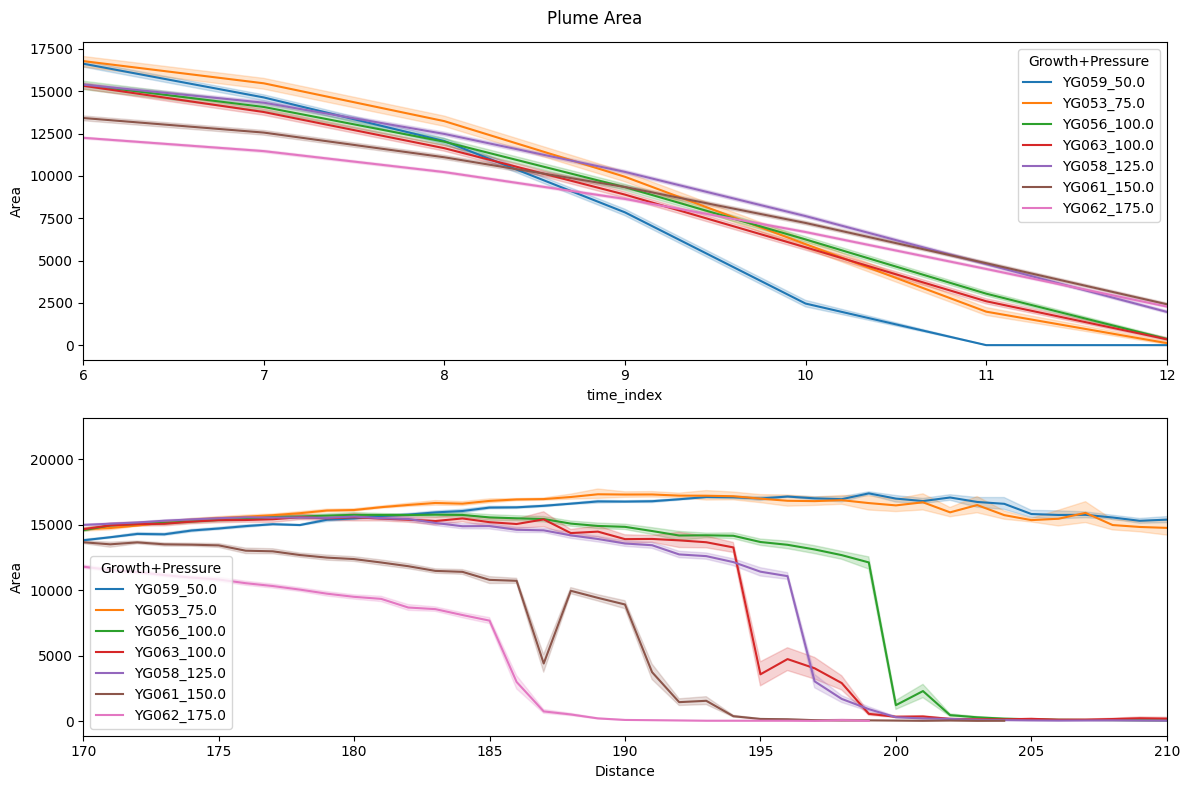

In [13]:
label = 'Growth+Pressure'

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Area", hue=label, data=df_merged_hotcore, ax=axes[0])
axes[0].set_xlim(6, 12)
lineplot = sns.lineplot(x="Distance", y="Area", hue=label, data=df_merged_hotcore, ax=axes[1])
# axes[1].set_title('Plume Area')
axes[1].set_xlim(170, 210)

plt.suptitle('Plume Area')
plt.tight_layout()
plt.show()

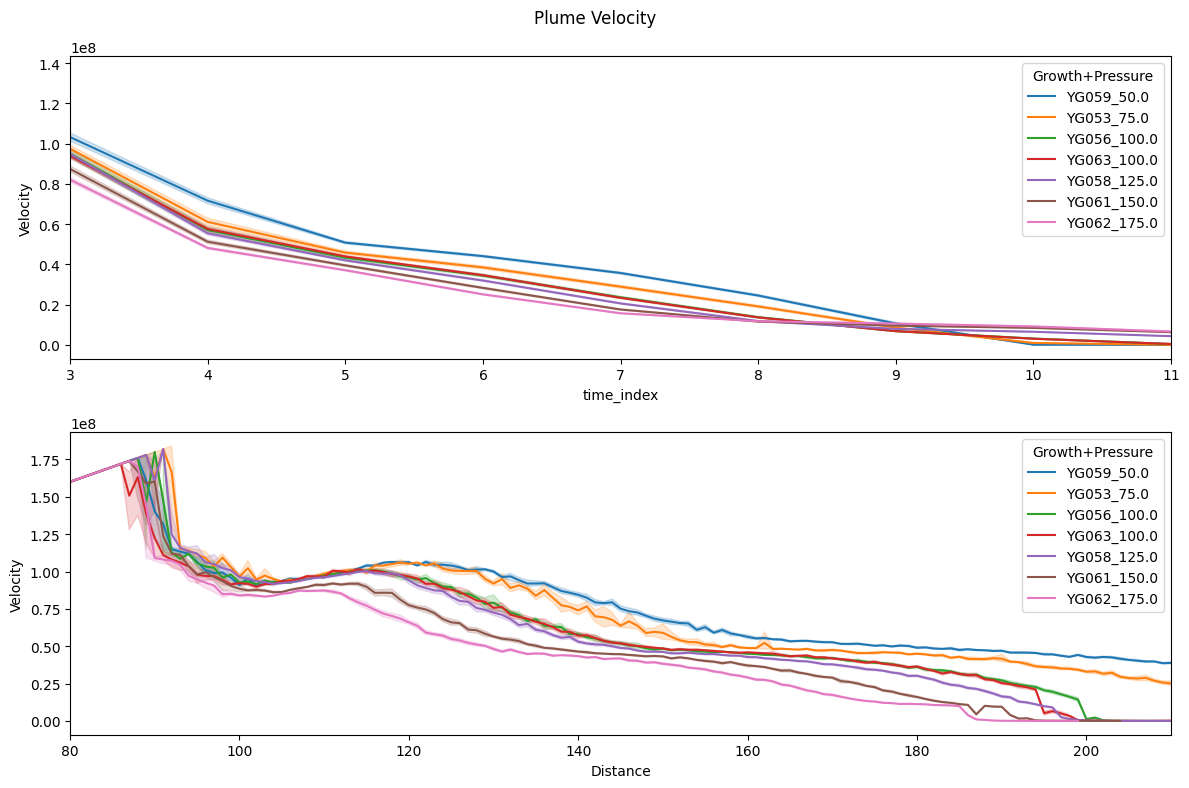

In [14]:
label = 'Growth+Pressure'

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
lineplot = sns.lineplot(x="time_index", y="Velocity", hue=label, data=df_merged_hotcore, ax=axes[0])
axes[0].set_xlim(3, 11)
lineplot = sns.lineplot(x="Distance", y="Velocity", hue=label, data=df_merged_hotcore, ax=axes[1])
axes[1].set_xlim(80, 210)

plt.suptitle('Plume Velocity')
plt.tight_layout()
plt.show()

## plume stablity

In [17]:
df_YG063 = df_merged[df_merged['Growth']=='YG063']
df_YG056 = df_merged[df_merged['Growth']=='YG056']
df_YG056_063 = pd.concat([df_YG063, df_YG056])
# print(df_YG063.sample(3), df_YG056.sample(3), )

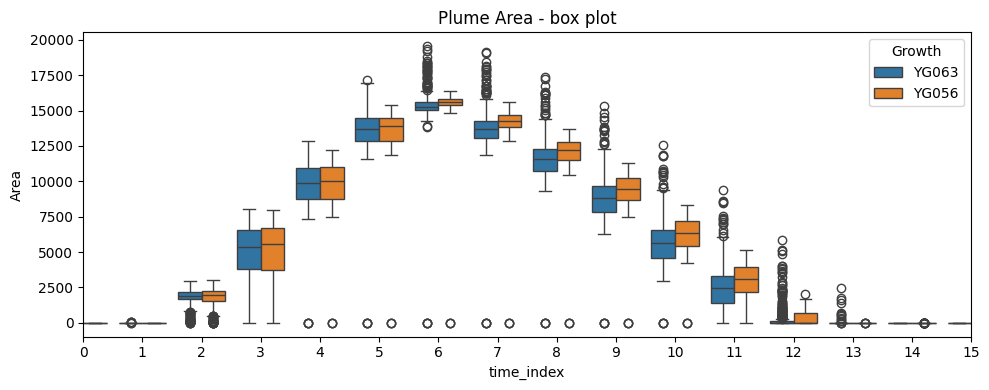

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='time_index', y='Area', hue='Growth', data=df_YG056_063[df_YG056_063['Threshold']=='200'])
# for flier in ax.collections[::2]:
#     flier.set_alpha(0.3)
ax.set_title('Plume Area - box plot')
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

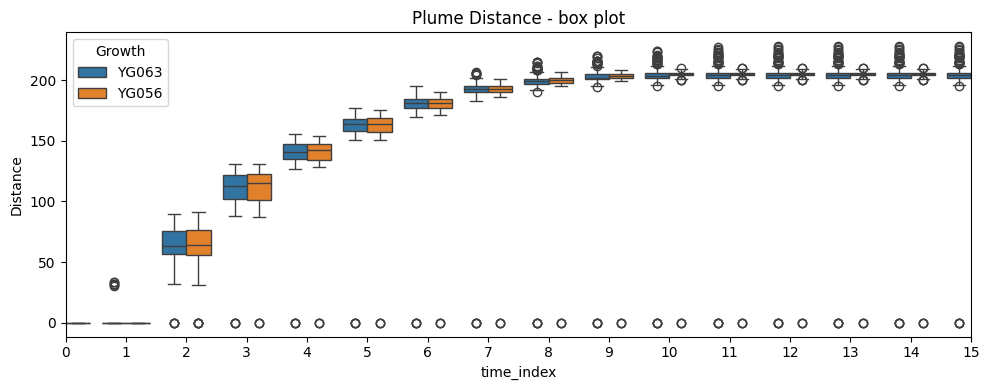

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='time_index', y='Distance', hue='Growth', data=df_YG056_063[df_YG056_063['Threshold']=='200'])
# for flier in ax.collections[::2]:
#     flier.set_alpha(0.3)
ax.set_title('Plume Distance - box plot')
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

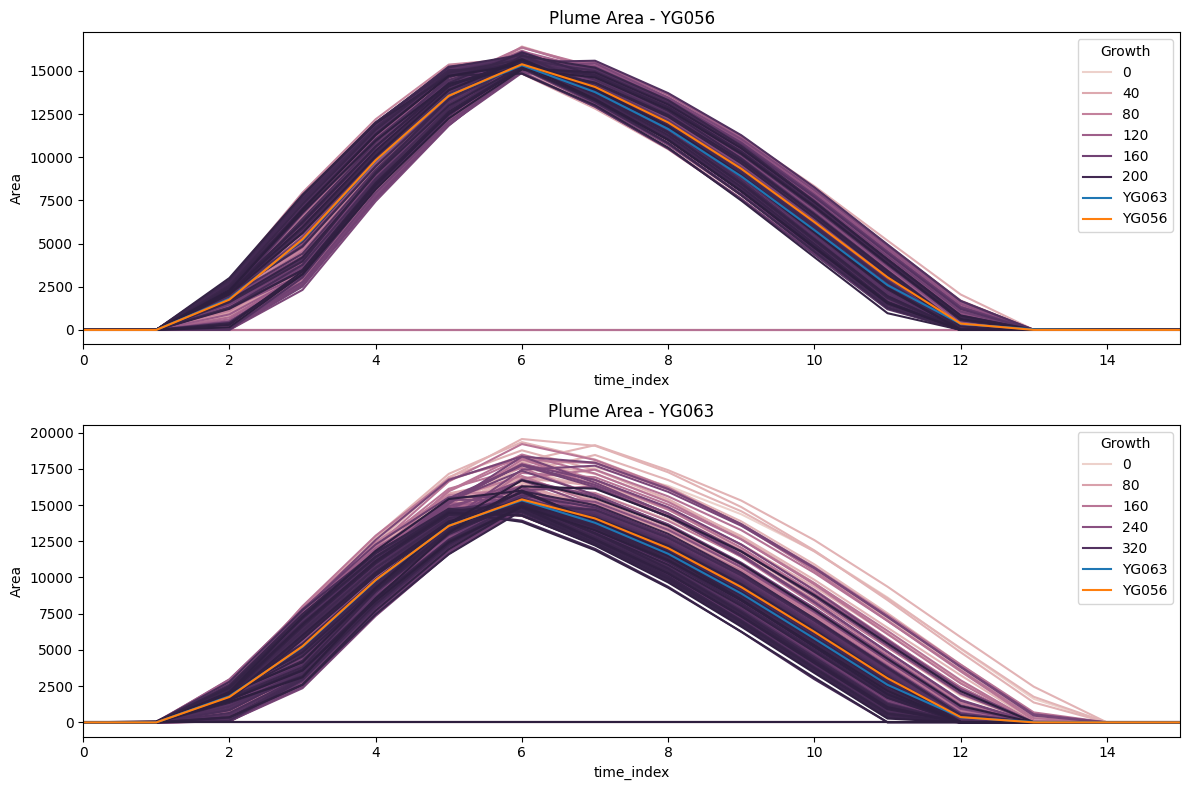

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_YG056[df_YG056['Threshold']=='200'], ax=axes[0])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_YG056_063[df_YG056_063['Threshold']=='200'], ax=axes[0])

axes[0].set_title('Plume Area - YG056')
axes[0].set_xlim(0, 15)

lineplot = sns.lineplot(x="time_index", y="Area", hue="plume_index", data=df_YG063[df_YG063['Threshold']=='200'], ax=axes[1])
lineplot = sns.lineplot(x="time_index", y="Area", hue="Growth", data=df_YG056_063[df_YG056_063['Threshold']=='200'], ax=axes[1])
axes[1].set_title('Plume Area - YG063')
axes[1].set_xlim(0, 15)

plt.tight_layout()
plt.show()